In [67]:
#imports
import pandas as pd     
import matplotlib.pyplot as plt    
%matplotlib inline
import seaborn as sns    
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
import os
sns.set(style="darkgrid")
from math import pi
from glob import glob
import re
import math
import scipy.interpolate as interp
from tslearn.metrics import dtw, dtw_path
from dtw import dtw,accelerated_dtw
from sklearn import preprocessing



#### Get Data

In [68]:
# Reference: https://perials.com/getting-csv-files-directory-subdirectories-using-python/
def getData(PATH, name):
#     PATH = "happinessData/"

    EXT = "*.csv"
    files = [file for path, subdir, files in os.walk(PATH)
                for file in glob(os.path.join(path, EXT))]
    l = []
    for f in files:
        df = pd.read_csv(f)
        result = re.search('/(.*).csv', f)
#         r = re.search('/(.*)',str(result.group(1)))
        video = result.group(1)
        df['video'] = np.full(len(df), video, dtype = int)
        l.append(df)
    df = pd.concat(l, ignore_index=True)
    df['name'] = name
    df = df.rename(columns=lambda x: x.strip())
    return df

#### Processing Data

In [69]:
def processData(df):
    df = df[df['success'] != 0]
    df = df[df['confidence'] > 0.80]
    # extracting features
    columns = df.columns
    gaze = [s for s in columns if "gaze" in s]
    pose = [s for s in columns if "pose" in s]
    AU = [s for s in columns if "_r" in s and "p" not in s]
    other = ['face_id','video']
   
    df = df[gaze+pose+AU+other]
    return df

In [70]:
# df = pd.DataFrame()
# df = getData("happiness_csv/", "happiness")
# df = processData(df)

In [71]:
df = pd.DataFrame()
df = getData("happiness_csv/", "happiness")
df = processData(df)

In [72]:
df.to_csv('happiness/happiness_data.csv')

#### Can read data from here

In [73]:
# df = pd.read_csv('happiness/happiness_data.csv')
# df = df.drop(columns = 'Unnamed: 0')

# df = pd.read_csv('sadness/sadness_data.csv')
# df = df.drop(columns = 'Unnamed: 0')

# df = pd.read_csv('anger/anger_data.csv')
# df = df.drop(columns = 'Unnamed: 0')

# df = pd.read_csv('disgust/disgust_data.csv')
# df = df.drop(columns = 'Unnamed: 0')

#### Process Data

Get Single Person Data - keep the most occuring face_id
Keep videos with more than 5 and less than 50 frames

In [74]:
videos = set(df['video'])
toRemove = []

for i in videos:
    lst = df[df['video']==i]['video'].tolist()
    if len(lst) <= 5:
        toRemove.append(i)
    df = df.drop(df[(df['video'] == i) & (df['video'] != max(lst,key=lst.count))].index)
    
    
for i in toRemove:
    videos.remove(i)
videos = list(videos)
df = df.drop(columns = 'face_id')

In [75]:
len(videos)

282

## Clustering Au for Single Data Using DTW

Compute DTW score seperately -> sum up scores

In [76]:
AU = [s for s in df.columns if "_r" in s and "p" not in s]
pose = [s for s in df.columns if "_r" in s and "pose" not in s]
gaze = [s for s in df.columns if "_r" in s and "gaze" not in s]

gaze_df = []
pose_df = []
AU_df = []
for i in videos:
    AU_df.append(df[df['video'] == i][AU])
    pose_df.append(df[df['video'] == i][pose])
    pose_df.append(df[df['video'] == i][gaze])

#### Compute DTW based on similarities between each AU features

I will use normalized AU scoring to identify similar patterns between them. Because I am only looking a signal patterns, I will remove low AU scoring columns to avoid false positive scorings

## Cluster Facial AU


#### Dropping Lower Scoring AU

In [77]:
def dropLowScore(video_df):
    
    # Removing videos with the lowest mean
    means = video_df.mean()
    percent20 = max(means)*0.2
    percent40 = max(means)*0.4

    low = video_df.loc[:, video_df.mean() < percent20]
    low = low.loc[:, video_df.max() < percent40]

    video_df = video_df.drop(columns = low.columns)
    return video_df

#### Get grouping of AU signal (selecting AU with largest value for grouping) using dtw
eg. select AU6 -> finding AU's with smallest dtw to AU6

Grouping using DTW scoring (better for busy data)

In [244]:
def getDTW(video_df):
    video_df = dropLowScore(video_df)
    sim_matrix = pd.DataFrame(index = video_df.columns)
    for key1 in video_df.columns:
        vid1 = []
        for key2 in video_df.columns: 
            a = video_df[key1]
            b = video_df[key2]
            a = np.array(a.div(max(a)))
            b = np.array(b.div(max(b)))
            d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(a,b, dist='euclidean')
            vid1.append(d)
        sim_matrix[key1] = vid1.copy()

    
    highest = video_df.loc[:, video_df.max() == max(video_df.max())]
    idx = list(highest.columns)[0]
    grouping = sim_matrix[sim_matrix[idx] < sim_matrix[idx].quantile(0.30)][idx].index.tolist()
    return grouping

Grouping using Euklidean scoring (better for simple data)

In [263]:
def getAbs(video_df):
    video_df = dropLowScore(video_df)
    sim_matrix = pd.DataFrame(index = video_df.columns)
    for key1 in video_df.columns:
        vid1 = []
        for key2 in video_df.columns: 
            a = video_df[key1]
            b = video_df[key2]
            a = np.array(a.div(max(a)))
            b = np.array(b.div(max(b)))
            d = sum(abs(a-b))
            vid1.append(d)
        sim_matrix[key1] = vid1.copy()

    
    highest = video_df.loc[:, video_df.max() == max(video_df.max())]
    idx = list(highest.columns)[0]
    grouping = sim_matrix[sim_matrix[idx] < sim_matrix[idx].quantile(0.30)][idx].index.tolist()
    return grouping

### Demonstrate grouping

In [280]:
# can change the (v) value and run the graphs to 
# see grouping of different clusters

v = 17

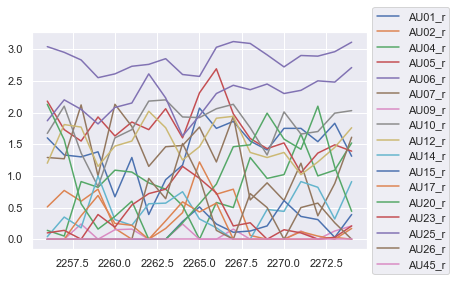

In [281]:
AU_df[v].plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

#### Sample Data containing similar signals after processing

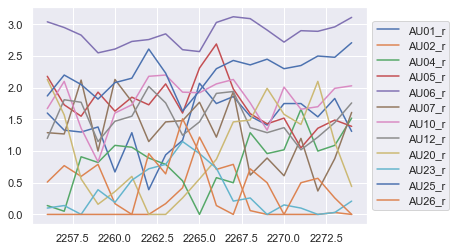

In [282]:
dropLowScore(AU_df[v]).plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

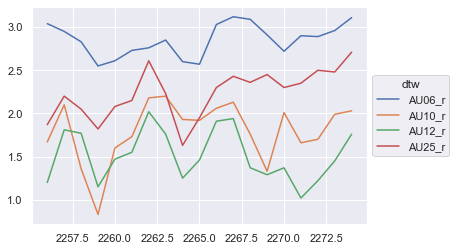

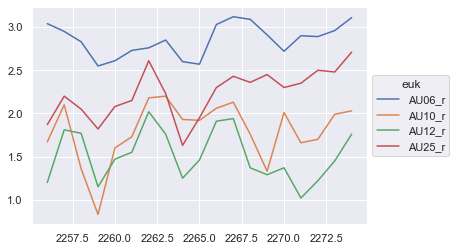

In [283]:
v=17
sample = dropLowScore(AU_df[v])
col = getDTW(AU_df[v])
sample[col].plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title ='dtw');
col = getAbs(AU_df[v])
sample[col].plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title='euk');

#### show video

In [268]:
from IPython.display import Image, display

X = Image(url='Gif/{}.gif'.format(videos[v]))
display(X)

## Grouping

#### Get AU grouping for entire dataframe

In [85]:
def getGrouping(df):
    groupings = []
    counter = 0
    for i in df:
        groupings.append(getDTW(i).copy())
        counter += 1
        print(counter)
    return groupings

#### Group Similar Clusters together -return cluster dataframe

In [86]:
def groupCluster(groupings):
    data = []
    for i in groupings:
        data.append(i)

    clusters = []
    N = [0]*len(videos)


    for elem in data:
        if len(elem) <= 1:
            continue
        if elem not in clusters:
            clusters.append(elem)
        N[clusters.index(elem)] += 1

    N = N[:len(clusters)]

    cluster_df = pd.DataFrame()
    cluster_df['N'] =  N
    cluster_df['clusters'] = clusters
    cluster_df = cluster_df[cluster_df['N'] > 1].sort_values(by=['N'], ascending=False)
    return data, cluster_df


## Find grouping for upper face AU

In [87]:
upper = ['AU01_r','AU02_r','AU04_r','AU05_r','AU06_r','AU07_r','AU09_r', 'AU45_r']
lower = ['AU10_r','AU12_r','AU14_r','AU15_r','AU17_r','AU20_r','AU23_r','AU25_r','AU26_r']
upper_au = df[upper]
lower_au = df[lower]

upper_df = []
lower_df = []
for i in AU_df:
    upper_df.append(i[upper])
    lower_df.append(i[lower])
# lower_df = df.drop(columns = upper)

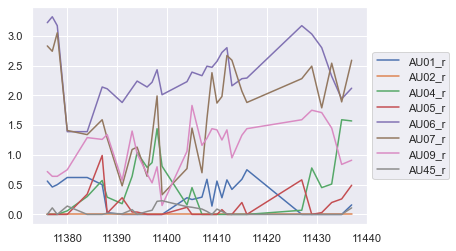

In [278]:
v = 22
sample = AU_df[v][upper]
sample.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

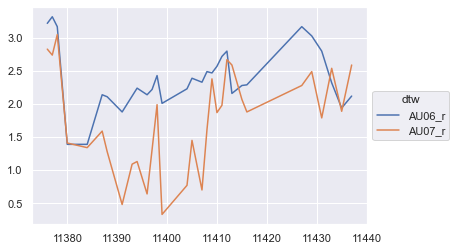

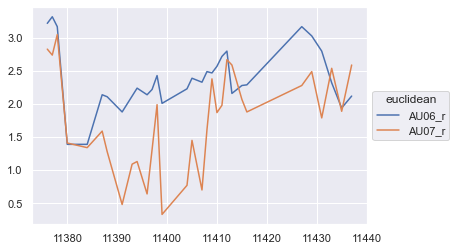

In [279]:

sample = dropLowScore(AU_df[v][upper])
col = getDTW(AU_df[v][upper])
sample[col].plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title ='dtw');
col = getAbs(AU_df[v][upper])
sample[col].plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title='euclidean');

In [259]:
from IPython.display import Image, display

X = Image(url='Gif/{}.gif'.format(videos[v]))
display(X)

#### Get Grouping Data

#### Getting Coupled Feature 
Note: this may take a little while to run

In [284]:
upper_groupings = getGrouping(upper_df)

In [92]:
upper_data, upper_cluster = groupCluster(upper_groupings)
upper_cluster.head(5)

,N,clusters
2,41,"[AU06_r, AU07_r]"
16,21,"[AU07_r, AU09_r]"
8,13,"[AU06_r, AU09_r]"
9,11,"[AU01_r, AU06_r]"
3,10,"[AU04_r, AU06_r]"


## Cluster by lower face AU

#### Get Grouping Data

In [285]:
# lower_groupings = getGrouping(lower_df)

In [94]:
lower_data, lower_cluster = groupCluster(lower_groupings)
lower_cluster.head(5)

,N,clusters
3,53,"[AU12_r, AU25_r]"
9,28,"[AU10_r, AU12_r]"
5,15,"[AU10_r, AU25_r]"
7,12,"[AU12_r, AU14_r]"
22,12,"[AU10_r, AU12_r, AU25_r]"


## Cluster both data

this takes some time to run

In [286]:
# groupings = getGrouping(AU_df)

Au6 is found in many clusters sharing similar dtw shape with Au12 and Au25. Which means changes au6 (cheek raiser), au12 (lip corner puller), and au25(lip part) usually occurs at the same time.

In [262]:
full_data, cluster = groupCluster(groupings)
cluster.head(10)

,N,clusters
3,18,"[AU06_r, AU12_r, AU25_r]"
28,11,"[AU06_r, AU12_r]"
52,9,"[AU06_r, AU10_r, AU12_r]"
7,7,"[AU06_r, AU07_r, AU12_r]"
19,6,"[AU06_r, AU10_r, AU25_r]"
24,6,"[AU06_r, AU12_r, AU14_r]"
17,5,"[AU06_r, AU10_r, AU12_r, AU25_r]"
66,5,"[AU12_r, AU25_r]"
0,4,"[AU06_r, AU07_r, AU25_r]"
119,4,"[AU06_r, AU07_r, AU10_r]"


### Graphing AU Relationship

In [97]:
def getRelation(au_data, au_label):
    
    percentage = pd.DataFrame(index = au_label)   
    for au in au_label:
        au_cluster = []
        # for i in lower_au_label:
        for data in au_data:
            if au in data:
                au_cluster.append(data)

        single_au = 0
        other_au = []
        for i in au_cluster:
            if i == [au]:
                single_au += 1
            else:
                for other in i:
                    if other != au:
                        other_au.append(other)

        length = len(other_au) + single_au
        au_percentage = []

        for i in au_label:
            if i == au:
                au_percentage.append(single_au/length)
            else:
                au_percentage.append(other_au.count(i)/length)


        percentage[au] = au_percentage
        percentage.columns.name='main_au'
        percentage.index.name='au_likelihood'
    percentage.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    

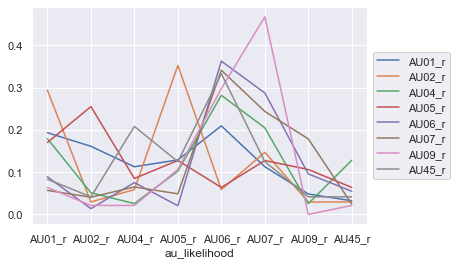

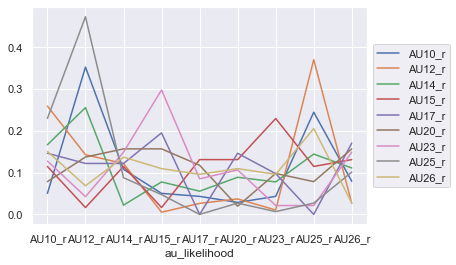

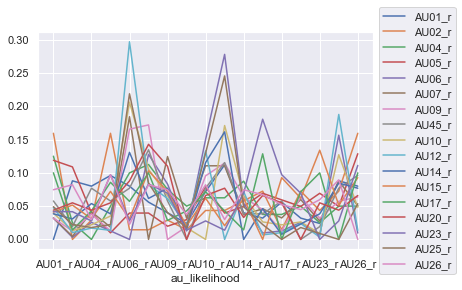

In [98]:
au_label = upper_au.columns.tolist()+lower_au.columns.tolist()

au_data = upper_data
getRelation(upper_data, upper_au.columns.tolist())
getRelation(lower_data, lower_au.columns.tolist())
getRelation(full_data, au_label)

# percentage.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

Discussion: 
au9: au7
au2: au1, au5
au45: au6 au4
au7: au6 (au9)
au6: au6 au7

## Noise reduction
#### (Preprocessing - Future Reference)

### Find local minima and maxima

Break dataframe into sections

In [99]:
v = 6
# for i in range(6,7):
sample = AU_df[v]

# getting highest valued AU
highest = sample.loc[:, sample.max() == max(sample.max())]
idx = list(highest.columns)[0]
a = np.array(sample[idx])

# finding local min
local_maxima = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True]
local_minima = np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True]

local_maxima = [i for i, e in enumerate(local_maxima) if e == 1]
local_minima = [i for i, e in enumerate(local_minima) if e == 1]

#break dataframe according to local minima
start = sample.index[0]
frames = []
for i,j in zip(local_minima,local_minima[1:]):
    frames.append(sample.truncate(before=start+i, after=start+j))
    if len(local_minima) < 2:
        continue

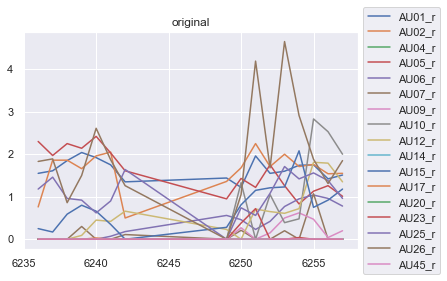

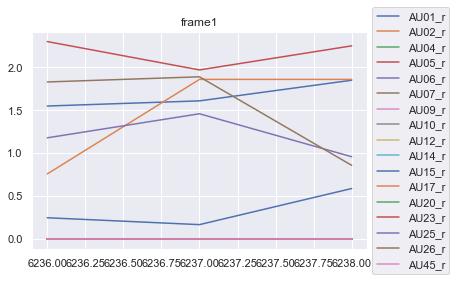

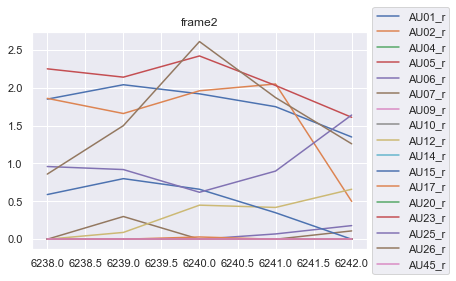

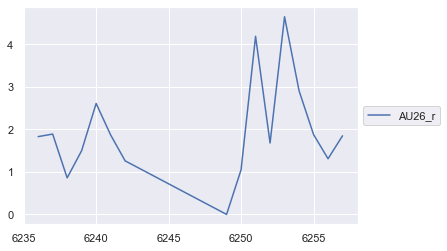

In [100]:
sample.plot(title="original").legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
frames[0].plot(title="frame1").legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
frames[1].plot(title="frame2").legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
sample[['AU26_r']].plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))